# Denoising example with a 2d image

In this notebook we show how to apply Clear-Skies to 2d image denoising. It simlates an observed noisey image and then applies constrained BPDN with a redundent dictionary to estimate the true signal.

In [1]:
import sys
#put path of Clear-Skies folder repository
sys.path.insert(0,'../../Clear-Skies')
#put path of Optimus Primal folder repository
sys.path.insert(0,'../../Optimus-Primal')
import numpy as np
from clearskies import solver
from clearskies import anscombe_transform
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

In [2]:
def open_fits(image_file):
    hdu_list = fits.open(image_file)
    return hdu_list[0].data
def open_header(image_file):
    hdu_list = fits.open(image_file)
    return hdu_list[0].header

Here we load the ground truth image

In [3]:
input_file = "../data/M51.fits"

x_true = open_fits(input_file)
header = open_header(input_file)
print(x_true.shape)

(256, 256)


Here we choose the noise level in db and add the noise

(array([ 9570., 34266.,  8086.,  4325.,  3094.,  2713.,  2007.,  1043.,
          390.,    42.]),
 array([ 19. ,  40.1,  61.2,  82.3, 103.4, 124.5, 145.6, 166.7, 187.8,
        208.9, 230. ]),
 <a list of 10 Patch objects>)

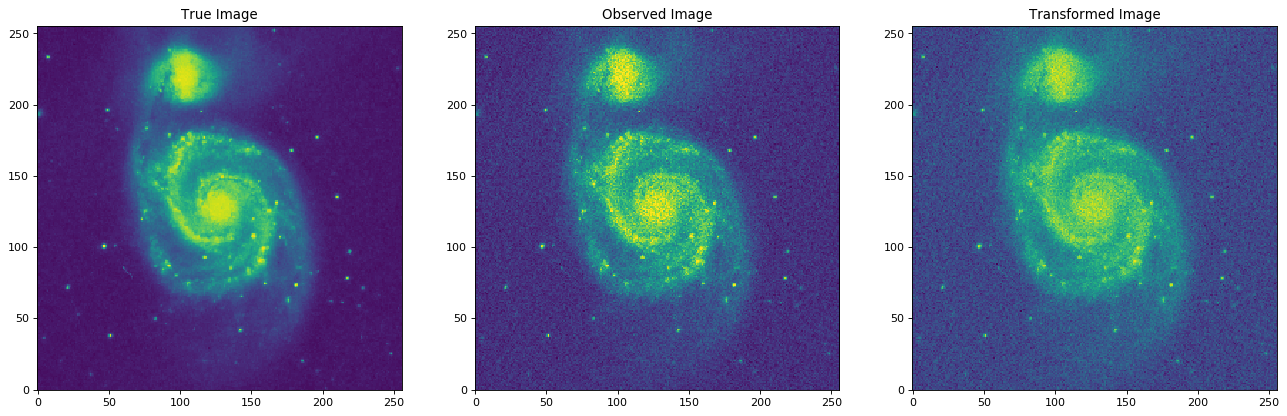

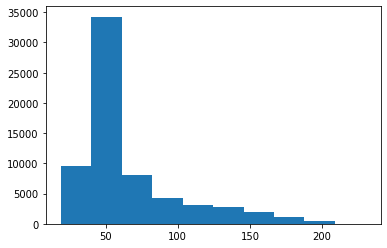

In [4]:
x_true = open_fits(input_file)
x_true = np.ceil(np.abs(x_true)/np.max(np.abs(x_true)) * 200)
background = x_true * 0 + 0
width, height = x_true.shape 
W = np.ones(x_true.shape)
y = np.random.poisson(lam=W * x_true + background)
y_gauss = anscombe_transform.anscombe(y)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), dpi=80, sharey=False, sharex=True)
ax[0].imshow(x_true, vmax=np.max(x_true),origin='lower')
ax[0].set_title("True Image")
ax[1].imshow(y, vmax=np.max(x_true),origin='lower')
ax[1].set_title("Observed Image")
ax[2].imshow(y_gauss, vmax=np.max(y_gauss),origin='lower')
ax[2].set_title("Transformed Image")
plt.figure()
plt.hist(np.ravel(y))

Below we choose the dictionary that we expect to represent our signal. Dirac is good for point sources, wavelets are good for extended and smooth signals on different scales. More levels is sometimes good for extended sources, but it deosn't always give the best results. Typically a redundent dictionary works well for many complex images, but it adds to the computation.

In [5]:
wav = ["db2", "db3", "db4"]
#wav = ["dct"]
#wav = ["db8"]
levels = 5

Here we choose the options for our algorithm, how iterations, real + positivity constraints, tollerance for convergence.

In [6]:
options = {'tol': 1e-4, 'iter': 5000, 'update_iter': 20, 'record_iters': False, 'positivity': True, 'real': True}
beta = 1e-4

Next we run the solver for our solution image $\mathbf{z}$ to the minimum of
$$ \|\mathbf{\Psi} \mathbf{x} \|_{\ell_1}\quad {\rm such\, that}\quad \|\mathbf{W} \mathbf{x} - \mathbf{W}\mathbf{y} \|_{\ell_2} \leq \epsilon $$
where $\epsilon = \sigma_{\rm noise}\sqrt{N + 2\sqrt{2N}}$. $\mathbf{\Psi}$ is the wavelet dictionary transform and $\mathbf{W}$ is the noise weights. $\|\mathbf{\alpha} \|_{\ell_1} = \sum_k |\alpha_k|$ and $\|\mathbf{\alpha} \|_{\ell_2} = \sqrt{\sum_k |\alpha_k|^2}$.

The basic idea is that $\mathbf{z}$  will not overfit to the signal because it can be efficiently represented with the dictionary.

In [8]:
z, diag = solver.solver(solver.algorithm.l1_poisson_constrained, y, 1, W, wav, levels, beta, options, background=background)

2020-07-18 01:03:13,671 - Clear Skies - INFO - Image shape (256, 256)
2020-07-18 01:03:13,672 - Clear Skies - INFO - Using wavelets ['db2', 'db3', 'db4'] with 5 levels
2020-07-18 01:03:13,672 - Clear Skies - INFO - Using an estimated noise level of 1 (weighted image units, i.e. Jy/Beam)
2020-07-18 01:03:13,688 - Clear Skies - INFO - Denosing using constrained l1 regularization with poisson constraint
2020-07-18 01:03:13,689 - Clear Skies - INFO - Ignoring Sigma since noise level is determined by the data
2020-07-18 01:03:13,689 - Clear Skies - INFO - Using background.
2020-07-18 01:03:13,714 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-07-18 01:03:13,758 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.500000
2020-07-18 01:03:15,361 - Optimus Primal - INFO - [Primal Dual] 20 out of 5000 iterations, tol = 0.001001
2020-07-18 01:03:16,052 - Optimus Primal - INFO - [Primal Dual] 40 out of 5000 iterations, tol = 0.000949
2020-07-18 01:03:17,1

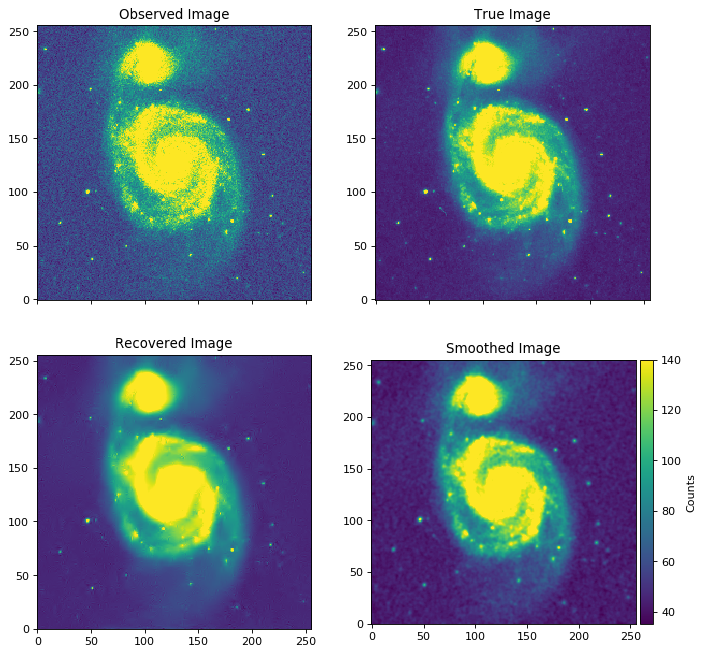

In [9]:
max_val = np.max(x_true) * 0.7
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi=80, sharey=False, sharex=True)
ax = np.ravel(ax)
ax[0].imshow(y, vmax=max_val,origin='lower')
ax[0].set_title("Observed Image")
ax[1].imshow(x_true, vmax=max_val,origin='lower')
ax[1].set_title("True Image")
ax[2].imshow(np.real(z), vmax=max_val,origin='lower')
ax[2].set_title("Recovered Image")
ax[3].set_title("Smoothed Image")
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(ax[3].imshow(gaussian_filter(y, 1), vmax=max_val,origin='lower'), cax=cax, orientation='vertical',label="Counts")